Inspired/based on https://github.com/rayidghani/magicloops and https://github.com/dssg/MLforPublicPolicy/blob/master/labs/2019/lab6_feature_generation_sol.ipynb

In [23]:
import pipeline_evictions as pipeline
import ml_loop_evictions as loop

import importlib
import datetime
import pandas as pd
import numpy as np

# Read data

In [24]:
importlib.reload(pipeline)

datafile = "data/tracts.csv"

#Read data, parsing year column to date type
data = pd.read_csv(datafile, parse_dates=['year'])

# Basic Cleaning

In [25]:
# Delete rows that do not have eviction-rate. We do not want to impute this value

data.dropna(subset=['eviction-rate'], inplace=True)
data['eviction-rate'].isnull().values.any()
data.reset_index(inplace=True, drop=True)

# Create outcome label

In [26]:
def get_eviction_rate(df, year,geoid):
    
  data_to_return = df.loc[(df['year'] == year) & (df['GEOID'] == geoid)]
  
  if(data_to_return.empty):
    return 0
  
  return data_to_return['eviction-rate'].iloc[0]

In [27]:
importlib.reload(pipeline)

from dateutil.relativedelta import relativedelta

#Obtain eviction-rate cutoff for the top 10%, for each year
cutoff_10_percent={}
for year in range(2000,2017):
    year = pd.Timestamp(year,1,1)
    cutoff_10_percent[year]=data.loc[data['year'] == year]['eviction-rate'].quantile(.9)
    
top_10_eviction_rate_in_any_next_3_years_column = np.zeros(len(data))

#We will take the chance of generating feature 'top 10% last year', which we will mainly used for baseline model
top_10_eviction_rate_last_year_column = np.zeros(len(data))

for index, row in data.iterrows():
  
  #Because the outcome will come from eviction-rate in next 3 years and we have data till 2016,
  #features data bust be from 2013 or before
  
  #We will also limit rows so that they all have one year before them (to calculate to_10_previous_year_feature)
 
  if(row['year']<=pd.Timestamp(2013,1,1) and row['year']>=pd.Timestamp(2001,1,1)):    
    
    found_year_where_eviction_was_in_top_10_percent=0
    
    #Get eviction for the next 3 years
    for i in range(1,4):
      date_in_i_years = row['year'] + relativedelta(years=i)
      eviction_rate_in_i_years = get_eviction_rate(data, date_in_i_years,row['GEOID'])
    
      top_10_eviction_rate_in_i_years = 1 if eviction_rate_in_i_years>= cutoff_10_percent[date_in_i_years] else 0
      

      
      #If we found one year that meets requirement, we are done with looping
      if(top_10_eviction_rate_in_i_years==1):
        found_year_where_eviction_was_in_top_10_percent=1
        break

    top_10_eviction_rate_in_any_next_3_years_column[index]=found_year_where_eviction_was_in_top_10_percent

    
    #Generating feature top 10% last year.
    date_last_years = row['year'] - relativedelta(years=1)
    eviction_rate_last_year = get_eviction_rate(data, date_last_years,row['GEOID'])
    top_10_eviction_rate_last_year = 1 if eviction_rate_last_year>= cutoff_10_percent[date_last_years] else 0

    top_10_eviction_rate_last_year_column[index] = top_10_eviction_rate_last_year
    
    
data['top_10_percent_in_any_next_3_years'] = top_10_eviction_rate_in_any_next_3_years_column

label ='top_10_percent_in_any_next_3_years'

#Append feature top 10% last year
data['top_10_percent_last_year']=top_10_eviction_rate_last_year_column



# Create temporal train and test sets

In [28]:
importlib.reload(pipeline)

#Create sets of train and test data, based on different split thresholds
#The split thresholds corresponds to the starting date of the testing data

#Splits according to https://docs.google.com/spreadsheets/d/1ipqsgThz7hdXXyyNpTuqa4J1inc088lop7lhFsAQ_r0/edit#gid=0
split_thresholds = [pd.Timestamp(i,1,1) for i in range (2005, 2014)]

#Indicating which is the column to be used for splitting training and test daata
date_column='year'

#Amount of data used for test set
test_window = relativedelta(years=4)

#Gap needed between training and test set
prediction_horizon = relativedelta(years=3)

#Gap needed for feature generation
feature_generation_gap = relativedelta(years=1)

#Generate train and test sets
train_test_sets= pipeline.create_temp_validation_train_and_testing_sets(
  data,
  date_column,
  label,
  split_thresholds,
  test_window,
  prediction_horizon,
  feature_generation_gap)

# Imputation

In [29]:
importlib.reload(pipeline)

#Impute data on continuous columns for each training and test set

float_columns = [column for column in data.columns if data[column].dtype=='float']

#Do not consider GEOID column nor top_10_percent_in_any_next_3_years
float_columns.remove('name')
float_columns.remove('top_10_percent_in_any_next_3_years')


for train_test_set in train_test_sets:
  train_data = train_test_set['x_train']
  test_data = train_test_set['x_test']

  #fill na values with mean
  pipeline.impute_data(train_data, float_columns)
  pipeline.impute_data(test_data, float_columns)


# Create features

In [30]:
import feature_generation as fg

importlib.reload(pipeline)
importlib.reload(fg)

#We will have to generate features independently for each different train/test set
for train_test_set in train_test_sets:

  train_features = fg.create_features(train_test_set['x_train'])
  test_features = fg.create_features(train_test_set['x_test']) 
  
  #Alternative for just working with default features
  #train_features, test_features = pipeline.create_features(train_test_set)
  
  #Replace raw data in train_test_set with features generated
  #Keep geoid
  train_test_set['x_train'] = train_test_set['x_train']['GEOID'].to_frame().reset_index(drop=True).join(train_features)
  train_test_set['x_test'] = train_test_set['x_test']['GEOID'].to_frame().reset_index(drop=True).join(test_features)
  

# Build Clasifiers and parameters generation

In [31]:
importlib.reload(pipeline)

#We define the specific models we want to run
models_to_run=['Baseline','DT','LR','RF','NB','BA','AB','GB']#,ET,KNN,SVM'

#Get all posible models and their different sets of parameters
models, parameters_grid = pipeline.get_models_and_parameters('test')

# Loop over models and different training/test sets

In [32]:
importlib.reload(pipeline)
importlib.reload(loop)

import warnings

warnings.filterwarnings('ignore')

results = loop.iterate_over_models_and_training_test_sets(models_to_run, models, parameters_grid, train_test_sets)
results

2019-06-12 14:37:03.101160: Running Baseline with params: {} on train/test set 2005-01-01 00:00:00
2019-06-12 14:37:03.442628: Running DT with params: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} on train/test set 2005-01-01 00:00:00
2019-06-12 14:37:03.752026: Running LR with params: {'C': 0.01, 'penalty': 'l1'} on train/test set 2005-01-01 00:00:00
2019-06-12 14:37:06.040769: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10} on train/test set 2005-01-01 00:00:00
2019-06-12 14:37:06.395338: Running NB with params: {} on train/test set 2005-01-01 00:00:00
2019-06-12 14:37:06.749939: Running BA with params: {'n_estimators': 10} on train/test set 2005-01-01 00:00:00
2019-06-12 14:37:07.748098: Running AB with params: {'algorithm': 'SAMME', 'n_estimators': 1} on train/test set 2005-01-01 00:00:00
2019-06-12 14:37:08.001751: Running GB with params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1, 'subsam

2019-06-12 14:38:40.597213: Running GB with params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1, 'subsample': 0.5} on train/test set 2012-01-01 00:00:00
2019-06-12 14:38:40.960872: Running Baseline with params: {} on train/test set 2013-01-01 00:00:00
2019-06-12 14:38:41.225063: Running DT with params: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} on train/test set 2013-01-01 00:00:00
2019-06-12 14:38:41.564056: Running LR with params: {'C': 0.01, 'penalty': 'l1'} on train/test set 2013-01-01 00:00:00
2019-06-12 14:39:05.009261: Running RF with params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10} on train/test set 2013-01-01 00:00:00
2019-06-12 14:39:05.457928: Running NB with params: {} on train/test set 2013-01-01 00:00:00
2019-06-12 14:39:06.117553: Running BA with params: {'n_estimators': 10} on train/test set 2013-01-01 00:00:00
2019-06-12 14:39:12.188756: Running AB with params: {'algorithm': 'SAMME', 'n_estim

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,Baseline,Baseline model,{},2005-01-01,0.140202,0.944444,0.064394,0.120567,0.918919,0.128788,...,0.409574,0.583333,0.481250,0.281915,0.602273,0.384058,0.182784,0.651515,0.285477,0.778655
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2005-01-01,0.140202,0.555556,0.037879,0.070922,0.675676,0.094697,...,0.502660,0.715909,0.590625,0.338652,0.723485,0.461353,0.212540,0.757576,0.331950,0.829233
2,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",2005-01-01,0.140202,0.722222,0.049242,0.092199,0.513514,0.071970,...,0.523936,0.746212,0.615625,0.379433,0.810606,0.516908,0.243358,0.867424,0.380083,0.856765
3,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2005-01-01,0.140202,1.000000,0.068182,0.127660,1.000000,0.140152,...,0.534574,0.761364,0.628125,0.393617,0.840909,0.536232,0.267800,0.954545,0.418257,0.915482
4,NB,"GaussianNB(priors=None, var_smoothing=1e-09)",{},2005-01-01,0.140202,0.333333,0.022727,0.042553,0.513514,0.071970,...,0.476064,0.678030,0.559375,0.351064,0.750000,0.478261,0.224230,0.799242,0.350207,0.806344
5,BA,"(KNeighborsClassifier(algorithm='auto', leaf_s...",{'n_estimators': 10},2005-01-01,0.140202,0.611111,0.041667,0.078014,0.405405,0.056818,...,0.183511,0.261364,0.215625,0.138298,0.295455,0.188406,0.121148,0.431818,0.189212,0.543006
6,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME', 'n_estimators': 1}",2005-01-01,0.140202,0.555556,0.037879,0.070922,0.675676,0.094697,...,0.502660,0.715909,0.590625,0.338652,0.723485,0.461353,0.212540,0.757576,0.331950,0.829233
7,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",2005-01-01,0.140202,0.666667,0.045455,0.085106,0.594595,0.083333,...,0.515957,0.734848,0.606250,0.349291,0.746212,0.475845,0.215728,0.768939,0.336929,0.832217
8,Baseline,Baseline model,{},2006-01-01,0.111524,0.277778,0.023810,0.043860,0.540541,0.095238,...,0.268617,0.480952,0.344710,0.191489,0.514286,0.279070,0.125399,0.561905,0.205039,0.714176
9,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2006-01-01,0.111524,0.777778,0.066667,0.122807,0.729730,0.128571,...,0.329787,0.590476,0.423208,0.221631,0.595238,0.322997,0.139214,0.623810,0.227628,0.754891


<Figure size 432x288 with 0 Axes>

# Observe best models for each train/test set, for different metrics

In [33]:
results

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,Baseline,Baseline model,{},2005-01-01,0.140202,0.944444,0.064394,0.120567,0.918919,0.128788,...,0.409574,0.583333,0.481250,0.281915,0.602273,0.384058,0.182784,0.651515,0.285477,0.778655
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2005-01-01,0.140202,0.555556,0.037879,0.070922,0.675676,0.094697,...,0.502660,0.715909,0.590625,0.338652,0.723485,0.461353,0.212540,0.757576,0.331950,0.829233
2,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",2005-01-01,0.140202,0.722222,0.049242,0.092199,0.513514,0.071970,...,0.523936,0.746212,0.615625,0.379433,0.810606,0.516908,0.243358,0.867424,0.380083,0.856765
3,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2005-01-01,0.140202,1.000000,0.068182,0.127660,1.000000,0.140152,...,0.534574,0.761364,0.628125,0.393617,0.840909,0.536232,0.267800,0.954545,0.418257,0.915482
4,NB,"GaussianNB(priors=None, var_smoothing=1e-09)",{},2005-01-01,0.140202,0.333333,0.022727,0.042553,0.513514,0.071970,...,0.476064,0.678030,0.559375,0.351064,0.750000,0.478261,0.224230,0.799242,0.350207,0.806344
5,BA,"(KNeighborsClassifier(algorithm='auto', leaf_s...",{'n_estimators': 10},2005-01-01,0.140202,0.611111,0.041667,0.078014,0.405405,0.056818,...,0.183511,0.261364,0.215625,0.138298,0.295455,0.188406,0.121148,0.431818,0.189212,0.543006
6,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME', 'n_estimators': 1}",2005-01-01,0.140202,0.555556,0.037879,0.070922,0.675676,0.094697,...,0.502660,0.715909,0.590625,0.338652,0.723485,0.461353,0.212540,0.757576,0.331950,0.829233
7,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",2005-01-01,0.140202,0.666667,0.045455,0.085106,0.594595,0.083333,...,0.515957,0.734848,0.606250,0.349291,0.746212,0.475845,0.215728,0.768939,0.336929,0.832217
8,Baseline,Baseline model,{},2006-01-01,0.111524,0.277778,0.023810,0.043860,0.540541,0.095238,...,0.268617,0.480952,0.344710,0.191489,0.514286,0.279070,0.125399,0.561905,0.205039,0.714176
9,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2006-01-01,0.111524,0.777778,0.066667,0.122807,0.729730,0.128571,...,0.329787,0.590476,0.423208,0.221631,0.595238,0.322997,0.139214,0.623810,0.227628,0.754891


In [34]:
importlib.reload(pipeline)

#Lets obtain the best model for each train/test set, for each metric
metrics_to_display = ['p_at_5','p_at_10', 'auc-roc']

best_models_per_metric = {}

for metric in metrics_to_display:
    #indices of rows that have max value in specific metric for each train/test set
    idx = results.groupby(['test_set_start_date'])[metric].transform(max) == results[metric]

    #save table of best models at the specific metric
    best_models_per_metric[metric] = results[idx]

### Best models for Precision at 5%

In [35]:
best_models_per_metric['p_at_5'].iloc[:, [0,2,3,4,11,12,13]]

,model_name,parameters,test_set_start_date,baseline,p_at_5,r_at_5,f1_at_5
3,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2005-01-01,0.140202,0.925532,0.329545,0.486034
15,GB,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",2006-01-01,0.111524,0.744681,0.333333,0.460526
19,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2007-01-01,0.154198,0.938462,0.301980,0.456929
27,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2008-01-01,0.145802,0.907692,0.308901,0.460937
35,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2009-01-01,0.146154,0.938462,0.321053,0.478431
43,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2010-01-01,0.170803,0.955882,0.277778,0.430464
50,LR,"{'C': 0.01, 'penalty': 'l1'}",2011-01-01,0.148040,0.941176,0.316206,0.473373
58,LR,"{'C': 0.01, 'penalty': 'l1'}",2012-01-01,0.149533,0.964706,0.320312,0.480938
67,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2013-01-01,0.146552,1.000000,0.341176,0.508772


### Best models for Precision at 10%

In [36]:
best_models_per_metric['p_at_10'].iloc[:, [0,2,3,4,14,15,16]]

,model_name,parameters,test_set_start_date,baseline,p_at_10,r_at_10,f1_at_10
0,Baseline,{},2005-01-01,0.140202,0.808511,0.575758,0.672566
8,Baseline,{},2006-01-01,0.111524,0.537234,0.480952,0.507538
19,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2007-01-01,0.154198,0.801527,0.519802,0.630631
27,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2008-01-01,0.145802,0.770992,0.528796,0.627329
39,GB,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",2009-01-01,0.146154,0.800000,0.547368,0.650000
42,LR,"{'C': 0.01, 'penalty': 'l1'}",2010-01-01,0.170803,0.905109,0.529915,0.668464
51,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2011-01-01,0.148040,0.841176,0.565217,0.676123
58,LR,"{'C': 0.01, 'penalty': 'l1'}",2012-01-01,0.149533,0.883041,0.589844,0.707260
66,LR,"{'C': 0.01, 'penalty': 'l1'}",2013-01-01,0.146552,0.873563,0.596078,0.708625


### Best models for AUC-ROC

In [37]:
best_models_per_metric['auc-roc'].iloc[:, [0,2,3,4,26]]

,model_name,parameters,test_set_start_date,baseline,auc-roc
3,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2005-01-01,0.140202,0.915482
11,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2006-01-01,0.111524,0.872689
19,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2007-01-01,0.154198,0.886677
27,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2008-01-01,0.145802,0.907804
35,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2009-01-01,0.146154,0.937224
43,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",2010-01-01,0.170803,0.931466
50,LR,"{'C': 0.01, 'penalty': 'l1'}",2011-01-01,0.148040,0.933607
58,LR,"{'C': 0.01, 'penalty': 'l1'}",2012-01-01,0.149533,0.946590
66,LR,"{'C': 0.01, 'penalty': 'l1'}",2013-01-01,0.146552,0.963746


### Plot of all model types performance at different train/test sets, for the different metrics

<Figure size 432x288 with 0 Axes>

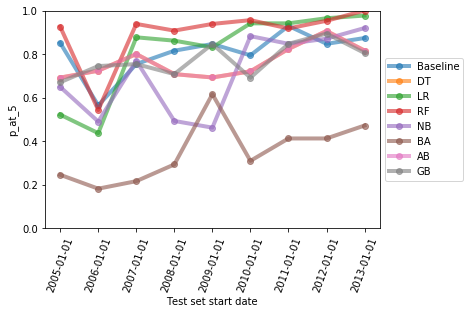

<Figure size 432x288 with 0 Axes>

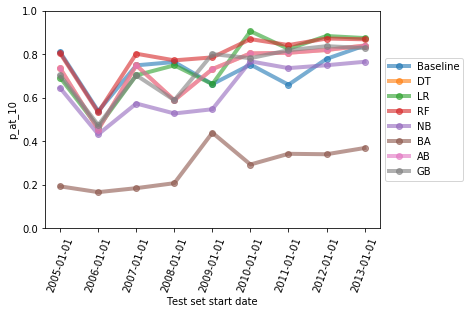

<Figure size 432x288 with 0 Axes>

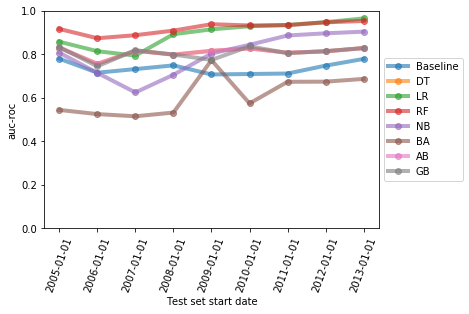

In [38]:
importlib.reload(pipeline)

best_models_per_metric = {}

for metric in metrics_to_display:
    #For each model, find the set of parameters that work the best in each train/test set
    best_models = pipeline.get_best_models_of_each_type_for_each_train_test_set(models_to_run,results,'test_set_start_date', metric)
    pipeline.plot_models_in_time(models_to_run, best_models, metric)
    best_models_per_metric[metric]=best_models
   